In [ ]:
#used this file
# STACKING ENSEMBLE WITH TABNET AS META MODEL


# 1️⃣ Import Libraries
import numpy as np
import pandas as pd
import joblib
import os
import torch  # Import PyTorch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from pytorch_tabnet.tab_model import TabNetClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import xgboost as xgb  # Import XGBoost native API


In [12]:

# 2️⃣ Load Dataset (Final Preprocessed CSV)
df = pd.read_csv("D:/FYP/data/datasets/final_dataset_02.csv")

# Separate features and labels
X = df.drop(columns=['label'])
y = df['label'].astype(int)


In [13]:

# 3️⃣ Load Base Models' Predictions
# Base models were trained and saved in .pkl format in the trained_models folder
base_model_paths = {
    "xgboost": "D:/FYP/models/trained_models/xgboost_native_model.pkl",  # Native XGBoost model
    "lightgbm": "D:/FYP/models/trained_models/lightgbm_intrusion_detection.pkl"  # LightGBM model
}

# Load trained base models
#xgb_model = xgb.Booster()  # Load native XGBoost model
xgb_model= joblib.load(base_model_paths["xgboost"])

lgb_model = joblib.load(base_model_paths["lightgbm"])  # Load LightGBM model


In [14]:

# 4️⃣ Generate Base Model Predictions (as Meta Features)
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Convert X_train and X_test to DMatrix for XGBoost predictions
xgb_train_dmatrix = xgb.DMatrix(X_train)
xgb_test_dmatrix = xgb.DMatrix(X_test)

# Get base model predictions (probabilities recommended for stacking)
xgb_train_preds = xgb_model.predict(xgb_train_dmatrix)  # XGBoost predictions
xgb_test_preds = xgb_model.predict(xgb_test_dmatrix)

lgb_train_preds = lgb_model.predict_proba(X_train)[:, 1]  # LightGBM predictions
lgb_test_preds = lgb_model.predict_proba(X_test)[:, 1]

# Create new meta-feature dataset for TabNet
X_meta_train = np.vstack((xgb_train_preds, lgb_train_preds)).T
X_meta_test = np.vstack((xgb_test_preds, lgb_test_preds)).T


d:\FYP\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "d:\FYP\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "C:\Users\MAHBOOB ALAM\AppData\Local\Programs\Python\Python313\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\MAHBOOB ALAM\AppData\Local\Programs\Python\Python313\Lib\subprocess.py", line 1036, in __init__
    self._execute_child(args, executable, preexec_fn, cl

In [15]:

# 5️⃣ Normalize Meta Features
scaler = StandardScaler()
X_meta_train_scaled = scaler.fit_transform(X_meta_train)
X_meta_test_scaled = scaler.transform(X_meta_test)


In [ ]:



# 6️⃣ Initialize TabNet Classifier
tabnet_model = TabNetClassifier(
    n_d=8, n_a=8,
    n_steps=3,
    gamma=1.5,
    lambda_sparse=1e-4,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    mask_type='sparsemax',
    verbose=10,
    seed=42
)

# 7️⃣ Train the TabNet Meta Model
tabnet_model.fit(
    X_meta_train_scaled, y_train.values,
    eval_set=[(X_meta_test_scaled, y_test.values)],
    eval_name=["valid"],
    eval_metric=["accuracy"],
    max_epochs=100,
    patience=20,
    batch_size=512,
    virtual_batch_size=128,
    num_workers=0
)


d:\FYP\.venv\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.02185 | valid_accuracy: 0.99996 |  0:00:26s
epoch 10 | loss: 0.00015 | valid_accuracy: 0.99996 |  0:04:43s
epoch 20 | loss: 0.00018 | valid_accuracy: 1.0     |  0:09:01s

Early stopping occurred at epoch 22 with best_epoch = 2 and best_valid_accuracy = 1.0


d:\FYP\.venv\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [18]:

# 8️⃣ Meta Model Predictions & Evaluation
y_meta_pred = tabnet_model.predict(X_meta_test_scaled)

# Evaluation
accuracy = accuracy_score(y_test, y_meta_pred)
print(f"\n✅ Meta Model Accuracy: {accuracy:.4f}")
print("\n✅ Classification Report:\n", classification_report(y_test, y_meta_pred))



✅ Meta Model Accuracy: 1.0000

✅ Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     13386
           1       1.00      1.00      1.00     13385

    accuracy                           1.00     26771
   macro avg       1.00      1.00      1.00     26771
weighted avg       1.00      1.00      1.00     26771



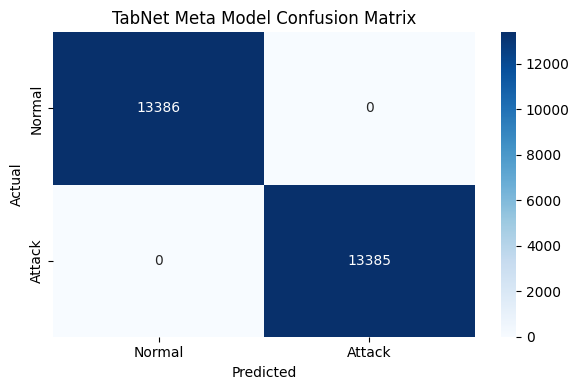

In [19]:

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_meta_pred)
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
plt.title("TabNet Meta Model Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


In [20]:

# 9️⃣ Save the Meta Model
os.makedirs("D:/FYP/models/trained_models", exist_ok=True)
joblib.dump(tabnet_model, "D:/FYP/models/trained_models/tabnet_meta_model.pkl")
print("✅ TabNet Meta Model saved at: D:/FYP/models/trained_models/tabnet_meta_model.pkl")

# Save the scaler too (important during inference)
joblib.dump(scaler, "D:/FYP/models/trained_models/meta_scaler.pkl")
print("✅ Meta feature scaler saved at: D:/FYP/models/trained_models/meta_scaler.pkl")

✅ TabNet Meta Model saved at: D:/FYP/models/trained_models/tabnet_meta_model.pkl
✅ Meta feature scaler saved at: D:/FYP/models/trained_models/meta_scaler.pkl
